In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

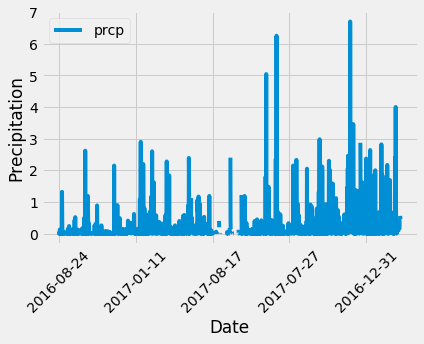

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
lastDate = session.query(func.max(measurement.date)).all()[0][0]
lastDate = dt.datetime.strptime(lastDate, '%Y-%m-%d')

# Calculate the date 1 year ago from the last data point in the database
priorYear = lastDate - dt.timedelta(365)

# Perform a query to retrieve the data and precipitation scores
result = session.query(measurement.date, measurement.prcp).filter(measurement.date>=priorYear).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(result).set_index("date")

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=45)
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.savefig("Precipitation_plot.png")
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(station.station).count()

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(measurement.station,func.count(measurement.station))\
.group_by(measurement.station)\
.order_by(func.count(measurement.station).desc())\
.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs))\
.filter(measurement.station == 'USC00519281').all()


[(54.0, 85.0, 71.66378066378067)]

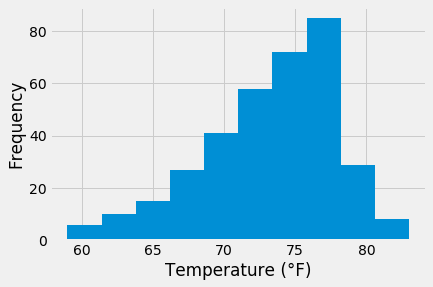

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and 
# plot the results as a histogram
rdata = session.query(measurement.tobs)\
.filter(measurement.station == 'USC00519281', measurement.date>=priorYear).all()
df = pd.DataFrame(rdata)
tobs = df["tobs"]
plt.hist(tobs)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.savefig("Temp_Histogram.png")
plt.show()

## Bonus Challenge Assignment

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2016-08-21', '2016-08-30'))

[(71.0, 77.9375, 84.0)]


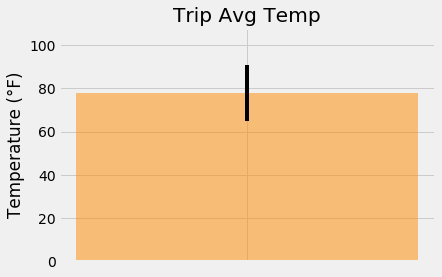

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tavg = [77.9375]
tmin = 71.0
tmax = 84.0
error = tmax-tmin
x_axis = np.arange(len(tavg))
plt.bar(x_axis, tavg, color='darkorange', alpha=0.5, align="center", yerr=error)
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, [""])
plt.ylabel('Temperature (°F)')
plt.ylim(0, max(tavg)+30)
plt.title("Trip Avg Temp")
plt.savefig("Trip_Avg_Temp.png")
plt.show()

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

session.query(func.sum(measurement.prcp),station.station, station.name, station.latitude, station.longitude, station.elevation).\
filter(measurement.prcp).filter(measurement.station == station.station).filter(measurement.date >= '2016-08-21').filter(measurement.date <= '2016-08-30')\
        .group_by(station.name)\
.order_by(func.sum(measurement.prcp).desc()).all()

[(7.560000000000001,
  'USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 (7.479999999999999,
  'USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 (4.16, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (2.55,
  'USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 (2.4,
  'USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 (0.69, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (0.06, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = [daily_normals("08-21"),daily_normals("08-22"),daily_normals("08-23"),daily_normals("08-24"),
           daily_normals("08-25"),daily_normals("08-26"),daily_normals("08-27"),daily_normals("08-28"),
           daily_normals("08-29"),daily_normals("08-30")]
normals

[[(67.0, 76.4, 83.0)],
 [(69.0, 76.47169811320755, 84.0)],
 [(67.0, 76.6923076923077, 87.0)],
 [(70.0, 75.96153846153847, 84.0)],
 [(69.0, 76.96078431372548, 82.0)],
 [(71.0, 76.56862745098039, 84.0)],
 [(68.0, 76.28301886792453, 84.0)],
 [(67.0, 76.73469387755102, 86.0)],
 [(70.0, 76.23529411764706, 85.0)],
 [(68.0, 76.41666666666667, 84.0)]]

In [27]:
# Set the start and end date of the trip
start_date = "2016-08-21"
end_date = "2016-08-30"
trip_dates = pd.date_range(start=start_date, end=end_date, freq='D')
# Use the start and end date to create a range of dates
# trip_dates = ["2016-08-21","2016-08-22","2016-08-23","2016-08-24","2016-08-25","2016-08-26","2016-08-27",
#               "2016-08-28","2016-08-29","2016-08-30"]

# Stip off the year and save a list of %m-%d strings
trip_dates2 = trip_dates.strftime('%m-%d')
# Loop through the list of %m-%d strings and calculate the normals for each date
normals2 = []
for date in trip_dates2:
    normals2.append(daily_normals(date))
normals2

[[(67.0, 76.4, 83.0)],
 [(69.0, 76.47169811320755, 84.0)],
 [(67.0, 76.6923076923077, 87.0)],
 [(70.0, 75.96153846153847, 84.0)],
 [(69.0, 76.96078431372548, 82.0)],
 [(71.0, 76.56862745098039, 84.0)],
 [(68.0, 76.28301886792453, 84.0)],
 [(67.0, 76.73469387755102, 86.0)],
 [(70.0, 76.23529411764706, 85.0)],
 [(68.0, 76.41666666666667, 84.0)]]

In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(
    {"Date": ["2016-08-21","2016-08-22","2016-08-23","2016-08-24","2016-08-25","2016-08-26","2016-08-27",
              "2016-08-28","2016-08-29","2016-08-30"],
     "Min Temp": [67.0, 69.0, 67.0, 70.0, 69.0, 71.0, 68.0, 67.0, 70.0, 68.0],
     "Avg Temp": [76.4, 76.47169811320755, 76.6923076923077, 75.96153846153847, 76.96078431372548, 
                  76.56862745098039, 76.28301886792453, 76.73469387755102, 76.23529411764706, 76.41666666666667],
    "Max Temp": [83.0, 84.0, 87.0, 84.0, 82.0, 84.0, 84.0, 86.0, 85.0, 84.0]}
).set_index("Date")
df

,Min Temp,Avg Temp,Max Temp
Date,,,
2016-08-21,67.0,76.400000,83.0
2016-08-22,69.0,76.471698,84.0
2016-08-23,67.0,76.692308,87.0
2016-08-24,70.0,75.961538,84.0
2016-08-25,69.0,76.960784,82.0
2016-08-26,71.0,76.568627,84.0
2016-08-27,68.0,76.283019,84.0
2016-08-28,67.0,76.734694,86.0
2016-08-29,70.0,76.235294,85.0


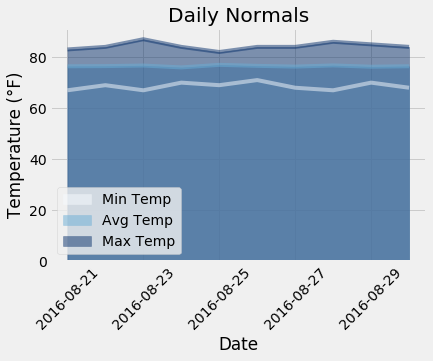

In [26]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind='area', stacked=False, alpha=0.5, colormap='Blues',
        title='Daily Normals', rot=45)
plt.ylabel('Temperature (°F)')
plt.savefig("Daily_Normals.png")
plt.show()